<a href="https://colab.research.google.com/github/Ach1207/Ach1207/blob/main/Neural_Network_Learning_with_Python_Part_3_Keras_Examples_1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Designing a binary-class classifier for the MNIST dataset (0 vs. 1).
The input can be the averages of the four quadrants (so 4 inputs + bias).

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from random import randint

def img_plt(images, labels):
  plt.figure()
  for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(images[i-1,:,:],cmap='gray')
    plt.title('Label: ' + str(labels[i-1]))
  plt.show()

def feat_extract(images):
  features=np.zeros((images.shape[0],4))
  features_temp=np.sum(images[:,0:int(images.shape[1]/2),
                              0:int(images.shape[2]/2)],axis=2) #quadrant 0
  features[:,0]=np.sum(features_temp,axis=1)/(14*14)
  features_temp=np.sum(images[:,0:int(images.shape[1]/2),
                              int(images.shape[2]/2):],axis=2) #quadrant 1
  features[:,1]=np.sum(features_temp,axis=1)/(14*14)
  features_temp=np.sum(images[:,int(images.shape[1]/2):,
                              0:int(images.shape[2]/2)],axis=2) #quadrant 2
  features[:,2]=np.sum(features_temp,axis=1)/(14*14)
  features_temp=np.sum(images[:,int(images.shape[1]/2):,
                              int(images.shape[2]/2):],axis=2) #quadrant 3
  features[:,3]=np.sum(features_temp,axis=1)/(14*14)
  return features

def feat_plot(features,labels,classes):
  plt.plot(features[labels[:]==classes[0],0], features[labels[:]==classes[0],1], 'rs',
         features[labels[:]==classes[1],0], features[labels[:]==classes[1],1], 'g^',markersize=15)
  plt.xlabel('x: feature 1')
  plt.ylabel('y: feature 2')
  plt.legend(['Class'+str(classes[0]), 'Class'+str(classes[1])])
  plt.show()

def acc_fun(labels_actual, labels_pred):
  acc=np.sum(labels_actual==labels_pred)/len(labels_actual)*100
  return acc

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Selecting only 0 and 1 digits from the training and testing sets
classes=[0,1]
x_train_01=x_train[np.logical_or(y_train==0,y_train==1),0:28,0:28]
y_train_01=y_train[np.logical_or(y_train==0,y_train==1)]
print('Samples of the training images')
img_plt(x_train_01[0:10,:,:],y_train_01[0:10])

x_test_01=x_test[np.logical_or(y_test==0,y_test==1),0:28,0:28]
y_test_01=y_test[np.logical_or(y_test==0,y_test==1)]
print('Samples of the testing images')
img_plt(x_test_01[0:10,:,:],y_test_01[0:10])

#Selecting 500 images from training data as the validation set
#shuffling trainig data
num_train_img=x_train_01.shape[0]
train_ind=np.arange(0,num_train_img)
train_ind_s=np.random.permutation(train_ind)
x_train_01=x_train_01[train_ind_s,:,:]
y_train_01=y_train_01[train_ind_s]
#Selecting 500 images for validation
x_val_01=x_train_01[0:500,:,:]
y_val_01=y_train_01[0:500]
#The rest of the training set
x_train_01=x_train_01[500:,:,:]
y_train_01=y_train_01[500:]
print('Samples of the validation images')
img_plt(x_val_01[0:10,:,:],y_val_01[0:10])

#Calculating the training, validation and testing feature (average of the four quadrants grid)
feature_train=feat_extract(x_train_01)
feature_val=feat_extract(x_val_01)
feature_test=feat_extract(x_test_01)

print('Plotting the features of 500 training images: ')
feat_plot(feature_train[1:500, 0:2],y_train_01[1:500], classes)
feat_plot(feature_train[1:500, 2:4],y_train_01[1:500], classes) #The combination between the features could be changed


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

def plot_curve(accuracy_train, loss_train):
  epochs=np.arange(loss_train.shape[0])
  plt.subplot(1,2,1)
  plt.plot(epochs,accuracy_train)
  plt.xlabel('Epoch#')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')

  plt.subplot(1,2,2)
  plt.plot(epochs,loss_train)
  plt.xlabel('Epoch#')
  plt.ylabel('Binary crossentropy loss')
  plt.title('Training loss')
  plt.show()

#defining the model
model_a=Sequential()
model_a.add(Dense(input_dim=4, units=100, activation='tanh'))
model_a.add(Dense(units=1, activation='sigmoid'))
model_a.summary()

opt = tf.keras.optimizers.SGD(learning_rate=0.001)  # try 0.01!
model_a.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history=model_a.fit(feature_train, y_train_01,
          batch_size=32,
          epochs=50,
          verbose=1)

score=model_a.evaluate(feature_train,y_train_01)
print('Total loss on training set: ', score[0])
print('Accuracy of training set: ', score[1])

#Evaluating the model on the validation samples
score=model_a.evaluate(feature_val,y_val_01)
print('Total loss on validation set: ', score[0])
print('Accuracy of validation set: ', score[1])

plt.figure(figsize=[9,5])
acc_curve=np.array(history.history['accuracy'])
loss_curve=np.array(history.history['loss'])
plot_curve(acc_curve,loss_curve)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#Evaluating the model on the held-out samples
score=model_a.evaluate(feature_test,y_test_01)
print('Total loss on testing set: ', score[0])
print('Accuracy using the testing set: ', score[1])

#predicting the class of the held-out samples
test_class1_prob=model_a.predict(feature_test)
test_lab=np.uint8(test_class1_prob>0.5)
print('The accuracy using the testing set: ',
      accuracy_score(test_lab,y_test_01))

conf_mat=confusion_matrix(test_lab,y_test_01)
print('The confusion matrix using testing set: \n', conf_mat)

print('The sensitivity using the testing set: %0.2f' %
      (conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])*100))
print('The specificity using the testing set: %0.2f' %
      (conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])*100))

# Designing a classifier for the MNIST dataset (0 vs. 1 vs. 2).
The input can be the averages of the four quadrants (so 4 inputs + bias).

Samples of the training images


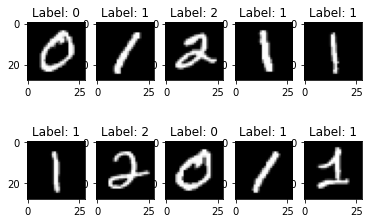

Samples of the testing images


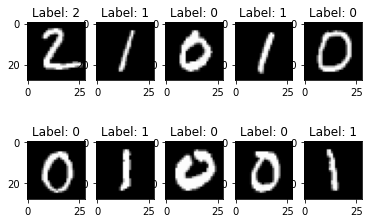

Samples of the validation images


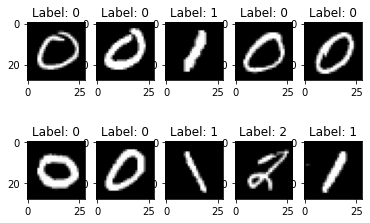

Plotting the features of 500 training images: 


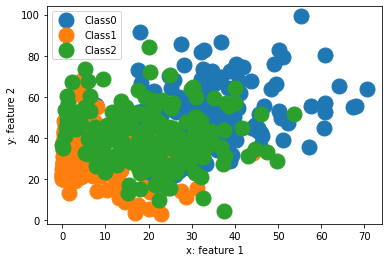

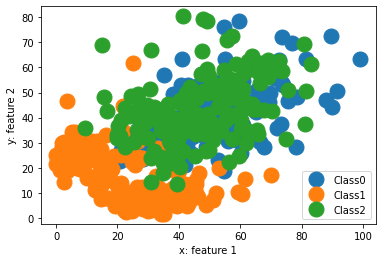

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from random import randint

def img_plt(images, labels):
  plt.figure()
  for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(images[i-1,:,:],cmap='gray')
    plt.title('Label: ' + str(labels[i-1]))
  plt.show()

def feat_extract(images):
  width=images.shape[1]
  height=images.shape[2]
  features=np.zeros((images.shape[0],4))
  features_temp=np.sum(images[:,0:int(width/2),0:int(height/2)],axis=2)#quadrant 0
  features[:,0]=np.sum(features_temp,axis=1)/(width*height/4)
  features_temp=np.sum(images[:,0:int(width/2),int(height/2):],axis=2) #quadrant 1
  features[:,1]=np.sum(features_temp,axis=1)/(width*height/4)
  features_temp=np.sum(images[:,int(width/2):,0:int(height/2)],axis=2) #quadrant 2
  features[:,2]=np.sum(features_temp,axis=1)/(width*height/4)
  features_temp=np.sum(images[:,int(width/2):,int(height/2):],axis=2)  #quadrant 3
  features[:,3]=np.sum(features_temp,axis=1)/(width*height/4)
  return features

def feat_plot(features,labels,classes):
  for class_i in classes:
    plt.plot(features[labels[:]==classes[class_i],0],
             features[labels[:]==classes[class_i],1],'o', markersize=15)
  #plt.axis([-2,2,-2,2])
  plt.xlabel('x: feature 1')
  plt.ylabel('y: feature 2')
  plt.legend(['Class'+str(classes[class_i]) for class_i in classes])
  plt.show()

def acc_fun(labels_actual, labels_pred):
  acc=np.sum(labels_actual==labels_pred)/len(labels_actual)*100
  return acc

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Selecting only 0 and 1 digits from the training and testing sets
classes=[0,1,2]
x_train_012=x_train[np.logical_or.reduce((y_train==0,y_train==1,y_train==2)),0:28,0:28]
y_train_012=y_train[np.logical_or.reduce((y_train==0,y_train==1,y_train==2))]
print('Samples of the training images')
img_plt(x_train_012[0:10,:,:],y_train_012[0:10])

x_test_012=x_test[np.logical_or.reduce((y_test==0,y_test==1,y_test==2)),0:28,0:28]
y_test_012=y_test[np.logical_or.reduce((y_test==0,y_test==1,y_test==2))]
print('Samples of the testing images')
img_plt(x_test_012[0:10,:,:],y_test_012[0:10])

#Selecting 500 images from training data as the validation set
#shuffling trainig data
num_train_img=x_train_012.shape[0]
train_ind=np.arange(0,num_train_img)
train_ind_s=np.random.permutation(train_ind)
x_train_012=x_train_012[train_ind_s,:,:]
y_train_012=y_train_012[train_ind_s]
#Selecting 500 images for validation
x_val_012=x_train_012[0:500,:,:]
y_val_012=y_train_012[0:500]
#The rest of the training set
x_train_012=x_train_012[500:,:,:]
y_train_012=y_train_012[500:]
print('Samples of the validation images')
img_plt(x_val_012[0:10,:,:],y_val_012[0:10])

#Calculating the training, validation and testing feature (average of the four quadrants grid)
feature_train=feat_extract(x_train_012)
feature_val=feat_extract(x_val_012)
feature_test=feat_extract(x_test_012)

print('Plotting the features of 500 training images: ')
feat_plot(feature_train[1:500, 0:2],y_train_012[1:500], classes)
feat_plot(feature_train[1:500, 2:4],y_train_012[1:500], classes)
#The combination between the features could be changed

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

def plot_curve(accuracy_train, loss_train):
  epochs=np.arange(loss_train.shape[0])
  plt.subplot(1,2,1)
  plt.plot(epochs,accuracy_train)
  #plt.axis([-1,2,-1,2])
  plt.xlabel('Epoch#')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')

  plt.subplot(1,2,2)
  plt.plot(epochs,loss_train)
  plt.xlabel('Epoch#')
  plt.ylabel('Binary crossentropy loss')
  plt.title('Training loss')
  plt.show()

#defining the model
model_a=Sequential()
model_a.add(Dense(input_dim=4, units=300, activation='tanh'))
model_a.add(Dense(units=10, activation='tanh'))
model_a.add(Dense(units=len(classes), activation='softmax'))
model_a.summary()

opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_a.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# convert class vectors to binary class matrices
from keras.utils.np_utils import to_categorical
y_train_012_c = to_categorical(y_train_012, len(classes))
y_val_012_c = to_categorical(y_val_012, len(classes))
y_test_012_c = to_categorical(y_test_012, len(classes))

history=model_a.fit(feature_train, y_train_012_c,
          batch_size=32,
          epochs=50,
          verbose=1)

#Evaluating the model on the training samples
score=model_a.evaluate(feature_train,y_train_012_c)
print('Total loss on training set: ', score[0])
print('Accuracy of training set: ', score[1])

#Evaluating the model on the validation samples
score=model_a.evaluate(feature_val,y_val_012_c)
print('Total loss on validation set: ', score[0])
print('Accuracy of validation set: ', score[1])

plt.figure(figsize=[9,5])
acc_curve=np.array(history.history['accuracy'])
loss_curve=np.array(history.history['loss'])
plot_curve(acc_curve,loss_curve)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
#Evaluating the model on the held-out samples
score=model_a.evaluate(feature_test,y_test_012_c)
print('Total loss on testing set: ', score[0])
print('Accuracy of testing set: ', score[1])

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
#predicting the class of the held-out samples
test_class1_prob=model_a.predict(feature_test)
test_lab=np.argmax(test_class1_prob,axis=1)
print('The accuracy using the testing set: ',
      accuracy_score(test_lab,y_test_012))
conf_mat=confusion_matrix(test_lab,y_test_012)
print('The confusion matrix using testing set: \n',
      conf_mat)